# Results of ConvNet vs. TSD, DANN, SCADANN models across 3 wearing locations on subject_1 

Library used can be downloaded from https://github.com/aonai/long_term_EMG_myo   
&emsp; Original by UlysseCoteAllard https://github.com/UlysseCoteAllard/LongTermEMG   
Dataset recorded by https://github.com/Suguru55/Wearable_Sensor_Long-term_sEMG_Dataset   
Extended robot project can be found in https://github.com/aonai/myo_robot_arm

### Notes 
* weights for ConvNet/TSD are total of 3 training models, 3 for each subject
* weights for DANN and SCADANN are total of 2 trianing models, 2 for each subject 


* training examples for ConvNet should have shape (1, 3, 40, 572, 4, 8, 10)
* training examples for TSD should have shape (1, 3, 40, 572, 252)
* training labels should have shape  (1, 3, 40, 572)


* location 0, 1, and 2 corresponds to neutral position, inward rotation, and outward roation respectively
* session mentioned below are wearing location, so number of sessions is 3

In [1]:
import os, sys
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import torch
import pandas as pd 

In [2]:
code_dir = "/home/laiy/gitrepos/msr_final/LongTermEMG_myo"
os.chdir(code_dir)
from PrepareAndLoadData.process_data import read_data_training

# 0. Prepare Data for ConvNet

### specify the directories used for running the code:
* `code_diar`: path to long_term_EMG_myo library
* `data_dir`: where raw dataset is loaded; raw data is in csv format
* `processed_data_dir`: where processed dataset is loaded; processed data is in npy pickle format
    * processed data should be a ndarray of shape   
    (controlling_factor_1 x controlling_factor_2 x num_sessions_per_gesture x #examples_window*#mov(26*22=572) x processed_channel_shape(252 for TSD, (4,8,10) for ConvNet)
* `path_<model_name>`: where model weights are saved
    * weights should be saved in folder `/Weights/<model_name>`. Each folder has subfolders containing weights for the first controlling factor.
    * weights for base model (TSD or ConvNet) contain m set of training model
    * weights for DANN and SCADANN contain m-1 set of trianing model (these models are trianed based on TSD, so they do not have a best_state_0.pt model). 
* `save_<model_name>`: where model results are saved
    * each result for testing a model on a group of dataset is saved in folder `results`. Each result has corresponding 
        * `<model_name>.txt` includes predictions, ground truths, array of accuracies for each participant and each session, and overall accuracy
        * `predictions_<model_name>.npy` includes array of accuracies, ground truths, predictions, and model outputs (probability array for each prediction)
        * remember to make blank files in these names before saving



* use `read_data_training` to process raw dataset
        

In [3]:
data_dir = "/home/laiy/gitrepos/msr_final/Wearable_Sensor_Long-term_sEMG_Dataset/data"
processed_data_dir_ConvNet = "/home/laiy/gitrepos/msr_final/LongTermEMG_myo/Processed_datasets_ConvNet"
processed_data_dir = "/home/laiy/gitrepos/msr_final/LongTermEMG_myo/Processed_datasets_ConvNet_TSD"

path_ConvNet ="/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/Weights_ConvNet/ConvNet"
save_ConvNet = "/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/results"

path_ConvNet_DANN ="/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/Weights_ConvNet/ConvNet_DANN"
save_ConvNet_DANN = "/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/results"

path_ConvNet_SCADANN ="/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/Weights_ConvNet/ConvNet_SCADANN"
save_ConvNet_SCADANN = "/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/results"

path_TSD ="/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/Weights_ConvNet/TSD"
save_TSD = "/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/results"

path_DANN ="/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/Weights_ConvNet/DANN"
save_DANN = "/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/results"

path_SCADANN ="/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/Weights_ConvNet/SCADANN"
save_SCADANN = "/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/results"

In [4]:
# read_data_training(path=data_dir, store_path = processed_data_dir_ConvNet, num_participant=1, spectrogram=True)

In [5]:
# check stored pickle 
with open(processed_data_dir_ConvNet + "/training_session.pickle", 'rb') as f:
    dataset_training = pickle.load(file=f)

examples_datasets_train_ConvNet = dataset_training['examples_training']
print('traning examples ', np.shape(examples_datasets_train_ConvNet))
labels_datasets_train_ConvNet = dataset_training['labels_training']
print('traning labels ', np.shape(labels_datasets_train_ConvNet))

traning examples  (1, 3, 40, 572, 4, 8, 10)
traning labels  (1, 3, 40, 572)


### Specify params used for training and testing ConvNet
During training and testing, processed datasets are first put into pytorch dataloders, then feed to the model trainer; following are params for ConvNet model and dataloaders

* `filter_size`: kernel size of ConvNet model; should be a 2d list of shape (m, 2), where m (4) is number of levels
* `num_kernels_ConvNet`: list of integers defining number of neurons used in each layer of linear block (linear block has `dropout`=0.5)

In [6]:
filter_size = [[3, 7], [3, 2], [3, 2], [2, 2]]
num_kernels_ConvNet = [16, 32, 64, 128]

# 0. Prepare Data for TSD

### specify the directories used for running the code:
* `code_diar`: path to long_term_EMG_myo library
* `data_dir`: where raw dataset is loaded; raw data is in csv format
* `processed_data_dir`: where processed dataset is loaded; processed data is in npy pickle format
    * processed data should be a ndarray of shape   
    (controlling_factor_1 x controlling_factor_2 x num_sessions_per_gesture x #examples_window*#mov(26*22=572) x processed_channel_shape(252 for TSD, (4,8,10) for ConvNet)
* `path_<model_name>`: where model weights are saved
    * weights should be saved in folder `/Weights/<model_name>`. Each folder has subfolders containing weights for the first controlling factor.
    * weights for base model (TSD or ConvNet) contain m set of training model
    * weights for DANN and SCADANN contain m-1 set of trianing model (these models are trianed based on TSD, so they do not have a best_state_0.pt model). 
* `save_<model_name>`: where model results are saved
    * each result for testing a model on a group of dataset is saved in folder `results`. Each result has corresponding 
        * `<model_name>.txt` includes predictions, ground truths, array of accuracies for each participant and each session, and overall accuracy
        * `predictions_<model_name>.npy` includes array of accuracies, ground truths, predictions, and model outputs (probability array for each prediction)
        * remember to make blank files in these names before saving



* use `read_data_training` to process raw dataset
        

In [7]:
# read_data_training(path=data_dir, store_path = processed_data_dir, num_participant=1)

In [8]:
# check stored pickle 
with open(processed_data_dir + "/training_session.pickle", 'rb') as f:
    dataset_training = pickle.load(file=f)

examples_datasets_train = dataset_training['examples_training']
print('traning examples ', np.shape(examples_datasets_train))
labels_datasets_train = dataset_training['labels_training']
print('traning labels ', np.shape(labels_datasets_train))

traning examples  (1, 3, 40, 572, 252)
traning labels  (1, 3, 40, 572)


### Specify params used for training and testing

During training and testing, processed datasets are first put into pytorch dataloders, then feed to the model trainer; following are params for TSD model and dataloaders

* `num_kernels`: list of integers defining number of neurons used in each linear layer (linear block has `dropout`=0.5)
* `number_of_cycles_total`: number of trails performed for each session (assuming that all session have the same trail size)
    * 40 for myo
* `number_of_classes`: total number of gestures performed in dataset
    * 22 for myo
* `batch_size`: number of examples stored in each batch
* `feature_vector_input_length`: length of input array or each processed signal; i.e. size of one training example 
    * 252 for TSD
* `learning_rate`= 0.002515
    

In [9]:
num_kernels=[200, 200, 200]                        
number_of_cycles_total=np.shape(examples_datasets_train[0][0])[0]              
print("number_of_cycles_total ", number_of_cycles_total)
number_of_classes=22
batch_size=128          
feature_vector_input_length=252                    
learning_rate=0.002515

number_of_cycles_total  40


# 1.a. ConvNet
* `train_fine_tuning`: used to train data using a base model (TSD or ConvNet)
    * running this function will save num_sessions sets of TSD model weights (each is fine tuned based on the previous training)  
    
* `test_standard_model_on_training_sessions`: test model result


### check if dataloaders are loaded correctly:
* each participant has shape (num_session x 40 x 572 x 4 x 8 x 10)
* each session has shape (40 x 572 x 4 x 8 x 10)
* put these data into on group ends up with shape (40*572=22880, 4, 8, 10)
    * shuffle on group of data and put into dataloaders
    * each participant should have num_sessions sets of dataloaders, each correspond to one session

In [10]:
from TrainingsAndEvaluations.ForTrainingSessions.train_tsd_dnn_standard import \
            test_standard_model_on_training_sessions, train_fine_tuning

In [11]:
# train_fine_tuning(examples_datasets_train_ConvNet, labels_datasets_train_ConvNet,
#                   num_kernels=num_kernels_ConvNet, path_weight_to_save_to=path_ConvNet,
#                   number_of_classes=number_of_classes, number_of_cycles_total=number_of_cycles_total,
#                   batch_size=batch_size,
#                   learning_rate=learning_rate,
#                   neural_net="Spectrogram", filter_size=filter_size)

In [12]:
algo_name = "standard_ConvNet"
test_standard_model_on_training_sessions(examples_datasets_train_ConvNet, labels_datasets_train_ConvNet,
                                  num_neurons=num_kernels_ConvNet, use_only_first_training=True,
                                  path_weights=path_ConvNet,
                                  save_path = save_ConvNet, algo_name=algo_name,
                                  number_of_cycles_total=number_of_cycles_total,
                                  number_of_classes=number_of_classes, cycle_for_test=3,
                                  neural_net="Spectrogram", filter_size=filter_size)

GET one participant_examples  (3, 40, 572, 4, 8, 10)
   GET one training_index_examples  (40, 572, 4, 8, 10)  at  0
   GOT one group XY  (22880, 4, 8, 10)    (22880,)
       one group XY test  (5720, 4, 8, 10)    (5720, 4, 8, 10)
       one group XY train (20592, 4, 8, 10)    (20592,)
       one group XY valid (2288, 4, 8, 10)    (2288, 4, 8, 10)
   GET one training_index_examples  (40, 572, 4, 8, 10)  at  1
   GOT one group XY  (22880, 4, 8, 10)    (22880,)
       one group XY test  (5720, 4, 8, 10)    (5720, 4, 8, 10)
       one group XY train (20592, 4, 8, 10)    (20592,)
       one group XY valid (2288, 4, 8, 10)    (2288, 4, 8, 10)
   GET one training_index_examples  (40, 572, 4, 8, 10)  at  2
   GOT one group XY  (22880, 4, 8, 10)    (22880,)
       one group XY test  (5720, 4, 8, 10)    (5720, 4, 8, 10)
       one group XY train (20592, 4, 8, 10)    (20592,)
       one group XY valid (2288, 4, 8, 10)    (2288, 4, 8, 10)
dataloaders: 
   train  (1, 3)
   valid  (1, 3)
   test  (1

In [13]:
results_filename = save_ConvNet + '/predictions_' + algo_name + "_no_retraining.npy"
results = np.load(results_filename, allow_pickle=True)
ConvNet_acc = results[0]
ConvNet_acc_overall = np.mean(ConvNet_acc)
ConvNet_df = pd.DataFrame(ConvNet_acc.transpose(), 
                       index = [f'Loc_{i}' for i in range(ConvNet_acc.shape[1])],
                        columns = [f'Participant_{j}' for j in range(ConvNet_acc.shape[0])])
ConvNet_df

,Participant_0
Loc_0,0.792133
Loc_1,0.535839
Loc_2,0.571154


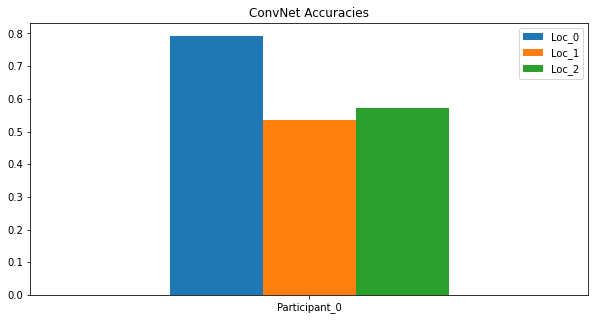

In [14]:
ConvNet_df.transpose().plot.bar(rot=0, figsize=(10,5))
plt.title("ConvNet Accuracies")
plt.show()

In [15]:
from TrainingsAndEvaluations.ForTrainingSessions.utils import get_gesture_accuracies

In [16]:
ground_truths = results[1]
predictions = results[2]
print("ground_truths  = ", np.shape(ground_truths))
print("predictions = ", np.shape(predictions))
m_name = "Sub"
n_name = "Loc"
df = get_gesture_accuracies(ground_truths, predictions, number_of_classes=number_of_classes, 
                            m_name=m_name, n_name=n_name, path=save_TSD, algo_name=algo_name)
df = pd.read_csv(save_ConvNet+'/'+algo_name+'.csv')
df

ground_truths  =  (1, 3)
predictions =  (1, 3)
index_participant_list  [0, 1, 2, 3, 4]
accuracies_gestures =  (22, 3)


,Unnamed: 0,Sub0_Loc0,Sub0_Loc1,Sub0_Loc2
0,M0,1.000000,1.000000,1.000000
1,M1,0.784615,0.415385,0.496154
2,M2,0.357692,0.057692,0.188462
3,M3,0.884615,0.434615,0.969231
4,M4,0.600000,0.684615,0.011538
5,M5,0.946154,0.442308,0.946154
6,M6,0.861538,0.384615,0.580769
7,M7,0.919231,0.819231,0.869231
8,M8,1.000000,0.996154,0.846154
9,M9,0.846154,0.550000,0.550000


# 1.b. TSD_DNN
* `train_fine_tuning`: used to train data using a base model (TSD or ConvNet)
    * running this function will save num_sessions sets of TSD model weights (each is fine tuned based on the previous training)  
    
* `test_standard_model_on_training_sessions`: test model result


### check if dataloaders are loaded correctly:
* each participant has shape (num_session x 40 x 572 x 252)
* each session has shape (40 x 572 x 252)
* put these data into on group ends up with shape (40*572=22880, 252)
    * shuffle on group of data and put into dataloaders
    * each participant should have num_sessions sets of dataloaders, each correspond to one session

In [17]:
from TrainingsAndEvaluations.ForTrainingSessions.train_tsd_dnn_standard import \
            test_standard_model_on_training_sessions, train_fine_tuning

In [18]:
# train_fine_tuning(examples_datasets_train, labels_datasets_train,
#                   num_kernels=num_kernels, path_weight_to_save_to=path_TSD,
#                   number_of_classes=number_of_classes, number_of_cycles_total=number_of_cycles_total,
#                   batch_size=batch_size,
#                   feature_vector_input_length=feature_vector_input_length,
#                   learning_rate=learning_rate)

In [19]:
algo_name = "standard_TSD"
test_standard_model_on_training_sessions(examples_datasets_train, labels_datasets_train,
                                  num_neurons=num_kernels, use_only_first_training=True,
                                  path_weights=path_TSD,
                                  feature_vector_input_length=feature_vector_input_length,
                                  save_path = save_TSD, algo_name=algo_name,
                                  number_of_cycles_total=number_of_cycles_total,
                                  number_of_classes=number_of_classes, cycle_for_test=3)

GET one participant_examples  (3, 40, 572, 252)
   GET one training_index_examples  (40, 572, 252)  at  0
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (5720, 252)    (5720, 252)
       one group XY train (20592, 252)    (20592,)
       one group XY valid (2288, 252)    (2288, 252)
   GET one training_index_examples  (40, 572, 252)  at  1
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (5720, 252)    (5720, 252)
       one group XY train (20592, 252)    (20592,)
       one group XY valid (2288, 252)    (2288, 252)
   GET one training_index_examples  (40, 572, 252)  at  2
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (5720, 252)    (5720, 252)
       one group XY train (20592, 252)    (20592,)
       one group XY valid (2288, 252)    (2288, 252)
dataloaders: 
   train  (1, 3)
   valid  (1, 3)
   test  (1, 3)
0  SESSION   data =  5720
Participant:  0  Accuracy:  0.9517482517482517
1  SESSION   data =  5720
Partic

In [20]:
results_filename = save_TSD + '/predictions_' + algo_name + "_no_retraining.npy"
results = np.load(results_filename, allow_pickle=True)
TSD_acc = results[0]
TSD_acc_overall = np.mean(TSD_acc)
TSD_df = pd.DataFrame(TSD_acc.transpose(), 
                       index = [f'Loc_{i}' for i in range(TSD_acc.shape[1])],
                        columns = [f'Participant_{j}' for j in range(TSD_acc.shape[0])])
TSD_df

,Participant_0
Loc_0,0.951748
Loc_1,0.69458
Loc_2,0.654371


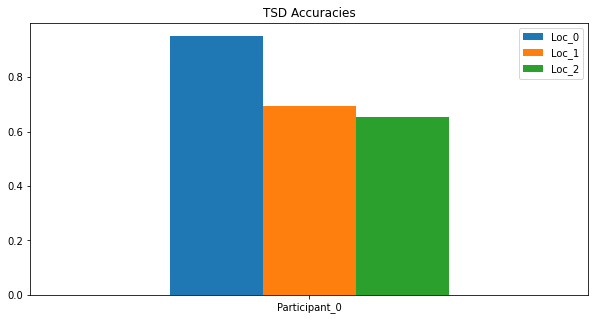

In [21]:
TSD_df.transpose().plot.bar(rot=0, figsize=(10,5))
plt.title("TSD Accuracies")
plt.show()

In [22]:
from TrainingsAndEvaluations.ForTrainingSessions.utils import get_gesture_accuracies

In [23]:
ground_truths = results[1]
predictions = results[2]
print("ground_truths  = ", np.shape(ground_truths))
print("predictions = ", np.shape(predictions))
m_name = "Sub"
n_name = "Loc"
df = get_gesture_accuracies(ground_truths, predictions, number_of_classes=number_of_classes, 
                            m_name=m_name, n_name=n_name, path=save_TSD, algo_name=algo_name)
df = pd.read_csv(save_TSD+'/'+algo_name+'.csv')
df

ground_truths  =  (1, 3)
predictions =  (1, 3)
index_participant_list  [0, 1, 2, 3, 4]
accuracies_gestures =  (22, 3)


,Unnamed: 0,Sub0_Loc0,Sub0_Loc1,Sub0_Loc2
0,M0,1.000000,1.000000,1.000000
1,M1,1.000000,0.569231,0.742308
2,M2,0.819231,0.415385,0.757692
3,M3,0.865385,0.392308,0.942308
4,M4,0.865385,0.792308,0.200000
5,M5,0.976923,0.423077,0.873077
6,M6,0.996154,0.634615,0.534615
7,M7,0.992308,0.630769,0.323077
8,M8,1.000000,0.980769,0.884615
9,M9,1.000000,0.730769,0.726923


# 2.a. ConvNet -> DANN
Train DANN model based on the weights from 1.a. ConvNet
* `train_DANN`: train DANN model using the first set of training weights from base model
    * num_sessions-1 sets of training weights will be saved
* `test_DANN_on_training_sessions`: test DANN model

In [24]:
from TrainingsAndEvaluations.ForTrainingSessions.train_tsd_dnn_DA import train_DANN, test_DANN_on_training_sessions

In [25]:
# train_DANN(examples_datasets_train_ConvNet, labels_datasets_train_ConvNet, 
#           num_kernels=num_kernels_ConvNet,
#           path_weights_fine_tuning=path_ConvNet,
#           number_of_classes=number_of_classes,
#           number_of_cycles_total = number_of_cycles_total,
#           batch_size=batch_size,
#           path_weights_to_save_to=path_ConvNet_DANN, 
#           learning_rate=learning_rate,
#           neural_net="Spectrogram", filter_size=filter_size)

In [26]:
algo_name = "ConvNet_DANN"
test_DANN_on_training_sessions(examples_datasets_train_ConvNet, labels_datasets_train_ConvNet,
                              num_neurons=num_kernels_ConvNet, path_weights_DA=path_ConvNet_DANN,
                              algo_name=algo_name, save_path = save_ConvNet_DANN, 
                              number_of_cycles_total=number_of_cycles_total,
                              path_weights_normal=path_ConvNet, number_of_classes=number_of_classes,
                              cycle_for_test=3, neural_net="Spectrogram", filter_size=filter_size)

GET one participant_examples  (3, 40, 572, 4, 8, 10)
   GET one training_index_examples  (40, 572, 4, 8, 10)  at  0
   GOT one group XY  (22880, 4, 8, 10)    (22880,)
       one group XY test  (5720, 4, 8, 10)    (5720, 4, 8, 10)
       one group XY train (20592, 4, 8, 10)    (20592,)
       one group XY valid (2288, 4, 8, 10)    (2288, 4, 8, 10)
   GET one training_index_examples  (40, 572, 4, 8, 10)  at  1
   GOT one group XY  (22880, 4, 8, 10)    (22880,)
       one group XY test  (5720, 4, 8, 10)    (5720, 4, 8, 10)
       one group XY train (20592, 4, 8, 10)    (20592,)
       one group XY valid (2288, 4, 8, 10)    (2288, 4, 8, 10)
   GET one training_index_examples  (40, 572, 4, 8, 10)  at  2
   GOT one group XY  (22880, 4, 8, 10)    (22880,)
       one group XY test  (5720, 4, 8, 10)    (5720, 4, 8, 10)
       one group XY train (20592, 4, 8, 10)    (20592,)
       one group XY valid (2288, 4, 8, 10)    (2288, 4, 8, 10)
dataloaders: 
   train  (1, 3)
   valid  (1, 3)
   test  (1

In [27]:
results_filename = save_ConvNet_DANN + '/predictions_' + algo_name + ".npy"
results = np.load(results_filename, allow_pickle=True)
ConvNet_DANN_acc = results[0]
ConvNet_DANN_acc_overall = np.mean(ConvNet_DANN_acc)
ConvNet_DANN_df = pd.DataFrame(ConvNet_DANN_acc.transpose(), 
                       index = [f'Loc_{i}' for i in range(ConvNet_DANN_acc.shape[1])],
                        columns = [f'Participant_{j}' for j in range(ConvNet_DANN_acc.shape[0])])
ConvNet_DANN_df

,Participant_0
Loc_0,0.792133
Loc_1,0.576573
Loc_2,0.620455


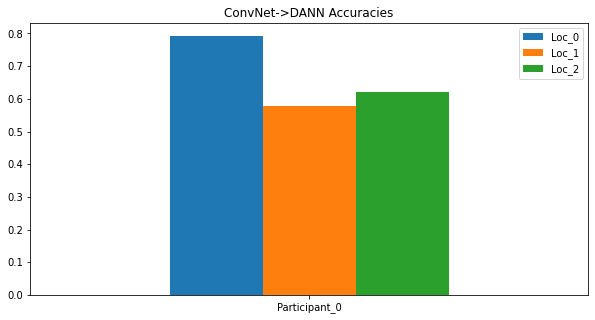

In [28]:
ConvNet_DANN_df.transpose().plot.bar(rot=0, figsize=(10,5))
plt.title("ConvNet->DANN Accuracies")
plt.show()

In [29]:
ground_truths = results[1]
predictions = results[2]
print("ground_truths  = ", np.shape(ground_truths))
print("predictions = ", np.shape(predictions))
m_name = "Sub"
n_name = "Loc"
df = get_gesture_accuracies(ground_truths, predictions, number_of_classes=number_of_classes, 
                            m_name=m_name, n_name=n_name, path=save_ConvNet_DANN, algo_name=algo_name)
df = pd.read_csv(save_ConvNet_DANN+'/'+algo_name+'.csv')
df

ground_truths  =  (1, 3)
predictions =  (1, 3)
index_participant_list  [0, 1, 2, 3, 4]
accuracies_gestures =  (22, 3)


,Unnamed: 0,Sub0_Loc0,Sub0_Loc1,Sub0_Loc2
0,M0,1.000000,1.000000,1.000000
1,M1,0.784615,0.384615,0.819231
2,M2,0.357692,0.253846,0.673077
3,M3,0.884615,0.465385,0.988462
4,M4,0.600000,0.830769,0.053846
5,M5,0.946154,0.542308,0.880769
6,M6,0.861538,0.588462,0.730769
7,M7,0.919231,0.815385,0.534615
8,M8,1.000000,0.984615,0.919231
9,M9,0.846154,0.603846,0.692308


# 2.b. TSD -> DANN
* `train_DANN`: train DANN model using the first set of training weights from base model
    * num_sessions-1 sets of training weights will be saved
* `test_DANN_on_training_sessions`: test DANN model

In [30]:
from TrainingsAndEvaluations.ForTrainingSessions.train_tsd_dnn_DA import train_DANN, test_DANN_on_training_sessions

In [31]:
# train_DANN(examples_datasets_train, labels_datasets_train, 
#           num_kernels=num_kernels,
#           path_weights_fine_tuning=path_TSD,
#           number_of_classes=number_of_classes,
#           number_of_cycles_total = number_of_cycles_total,
#           batch_size=batch_size,
#           feature_vector_input_length=feature_vector_input_length,
#           path_weights_to_save_to=path_DANN, learning_rate=learning_rate)

In [32]:
algo_name = "DANN"
test_DANN_on_training_sessions(examples_datasets_train, labels_datasets_train,
                              feature_vector_input_length=feature_vector_input_length,
                              num_neurons=num_kernels, path_weights_DA=path_DANN,
                              algo_name=algo_name, save_path = save_DANN, 
                              number_of_cycles_total=number_of_cycles_total,
                              path_weights_normal=path_TSD, number_of_classes=number_of_classes,
                              cycle_for_test=3)

GET one participant_examples  (3, 40, 572, 252)
   GET one training_index_examples  (40, 572, 252)  at  0
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (5720, 252)    (5720, 252)
       one group XY train (20592, 252)    (20592,)
       one group XY valid (2288, 252)    (2288, 252)
   GET one training_index_examples  (40, 572, 252)  at  1
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (5720, 252)    (5720, 252)
       one group XY train (20592, 252)    (20592,)
       one group XY valid (2288, 252)    (2288, 252)
   GET one training_index_examples  (40, 572, 252)  at  2
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (5720, 252)    (5720, 252)
       one group XY train (20592, 252)    (20592,)
       one group XY valid (2288, 252)    (2288, 252)
dataloaders: 
   train  (1, 3)
   valid  (1, 3)
   test  (1, 3)
(3,)
Participant ID:  0  Session ID:  0  Accuracy:  0.9517482517482517
Participant ID:  0  Session ID:  1

In [33]:
results_filename = save_DANN + '/predictions_' + algo_name + ".npy"
results = np.load(results_filename, allow_pickle=True)
DANN_acc = results[0]
DANN_acc_overall = np.mean(DANN_acc)
DANN_df = pd.DataFrame(DANN_acc.transpose(), 
                       index = [f'Loc_{i}' for i in range(DANN_acc.shape[1])],
                        columns = [f'Participant_{j}' for j in range(DANN_acc.shape[0])])
DANN_df

,Participant_0
Loc_0,0.951748
Loc_1,0.698077
Loc_2,0.720455


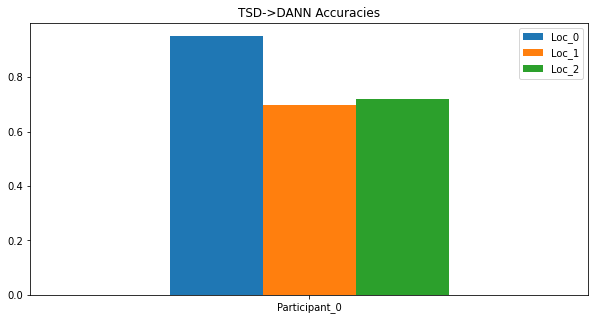

In [34]:
DANN_df.transpose().plot.bar(rot=0, figsize=(10,5))
plt.title("TSD->DANN Accuracies")
plt.show()

In [35]:
ground_truths = results[1]
predictions = results[2]
print("ground_truths  = ", np.shape(ground_truths))
print("predictions = ", np.shape(predictions))
m_name = "Sub"
n_name = "Loc"
df = get_gesture_accuracies(ground_truths, predictions, number_of_classes=number_of_classes, 
                            m_name=m_name, n_name=n_name, path=save_DANN, algo_name=algo_name)
df = pd.read_csv(save_DANN+'/'+algo_name+'.csv')
df

ground_truths  =  (1, 3)
predictions =  (1, 3)
index_participant_list  [0, 1, 2, 3, 4]
accuracies_gestures =  (22, 3)


,Unnamed: 0,Sub0_Loc0,Sub0_Loc1,Sub0_Loc2
0,M0,1.000000,1.000000,1.000000
1,M1,1.000000,0.719231,0.830769
2,M2,0.819231,0.496154,0.873077
3,M3,0.865385,0.465385,0.980769
4,M4,0.865385,0.623077,0.253846
5,M5,0.976923,0.465385,0.900000
6,M6,0.996154,0.634615,0.773077
7,M7,0.992308,0.769231,0.580769
8,M8,1.000000,0.969231,0.946154
9,M9,1.000000,0.780769,0.834615


# 3.a. ConvNet -> SCADANN
Train SCADANN model based on the weights in 1.a. ConvNet and 2.a. DANN
* `run_SCADANN_training_sessions`: train SCADANN model. The first session uses TSD model_0 wegits; others use DANN weights
    * specify `percentage_same_gesture_stable` based on the performance of most pseudo labels: 
        * print accuracies out and check what percentage will optimize `ACCURACY MODEL` and `ACCURACY PSEUDO` without cutting out too much data 
    * num_sessions-1 sets of training weights will be saved
* `test_network_SLADANN`: test DANN model

In [36]:
from TrainingsAndEvaluations.ForTrainingSessions.train_tsd_dnn_SCADANN import run_SCADANN_training_sessions, test_network_SCADANN

In [37]:
# percentage_same_gesture_stable = 0.75 
# run_SCADANN_training_sessions(examples_datasets=examples_datasets_train_ConvNet, labels_datasets=labels_datasets_train_ConvNet,
#                               num_kernels=num_kernels_ConvNet, 
#                               path_weights_to_save_to=path_ConvNet_SCADANN,
#                               path_weights_Adversarial_training=path_ConvNet_DANN,
#                               path_weights_Normal_training=path_ConvNet,
#                               number_of_cycles_total = number_of_cycles_total, 
#                               number_of_classes=number_of_classes,
#                               learning_rate=learning_rate,
#                               neural_net="Spectrogram", filter_size=filter_size)

In [38]:
algo_name = "ConvNet_SCADANN"
test_network_SCADANN(examples_datasets_train=examples_datasets_train_ConvNet, 
                     labels_datasets_train=labels_datasets_train_ConvNet,
                     num_neurons=num_kernels_ConvNet, 
                     path_weights_SCADANN =path_ConvNet_SCADANN, path_weights_normal=path_ConvNet,
                     algo_name=algo_name, cycle_test=3, number_of_cycles_total=number_of_cycles_total,
                     number_of_classes=number_of_classes, save_path = save_ConvNet_SCADANN,
                     neural_net="Spectrogram", filter_size=filter_size)

GET one participant_examples  (3, 40, 572, 4, 8, 10)
   GET one training_index_examples  (40, 572, 4, 8, 10)  at  0
   GOT one group XY  (22880, 4, 8, 10)    (22880,)
       one group XY test  (5720, 4, 8, 10)    (5720, 4, 8, 10)
       one group XY train (20592, 4, 8, 10)    (20592,)
       one group XY valid (2288, 4, 8, 10)    (2288, 4, 8, 10)
   GET one training_index_examples  (40, 572, 4, 8, 10)  at  1
   GOT one group XY  (22880, 4, 8, 10)    (22880,)
       one group XY test  (5720, 4, 8, 10)    (5720, 4, 8, 10)
       one group XY train (20592, 4, 8, 10)    (20592,)
       one group XY valid (2288, 4, 8, 10)    (2288, 4, 8, 10)
   GET one training_index_examples  (40, 572, 4, 8, 10)  at  2
   GOT one group XY  (22880, 4, 8, 10)    (22880,)
       one group XY test  (5720, 4, 8, 10)    (5720, 4, 8, 10)
       one group XY train (20592, 4, 8, 10)    (20592,)
       one group XY valid (2288, 4, 8, 10)    (2288, 4, 8, 10)
dataloaders: 
   train  (1, 3)
   valid  (1, 3)
   test  (1

In [39]:
results_filename = save_ConvNet_SCADANN + '/predictions_' + algo_name + ".npy"
results = np.load(results_filename, allow_pickle=True)
ConvNet_SCADANN_acc = results[0]
ConvNet_SCADANN_acc_overall = np.mean(ConvNet_SCADANN_acc)
ConvNet_SCADANN_df = pd.DataFrame(ConvNet_SCADANN_acc.transpose(), 
                       index = [f'Loc_{i}' for i in range(ConvNet_SCADANN_acc.shape[1])],
                        columns = [f'Participant_{j}' for j in range(ConvNet_SCADANN_acc.shape[0])])
ConvNet_SCADANN_df

,Participant_0
Loc_0,0.792133
Loc_1,0.641608
Loc_2,0.631119


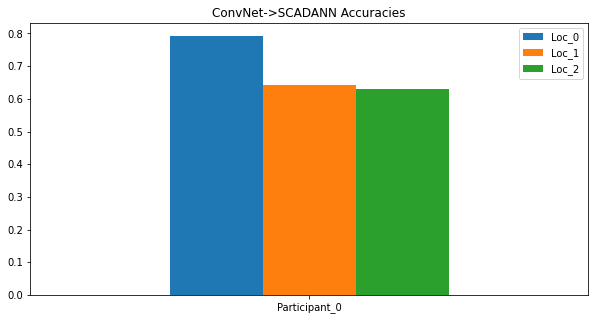

In [40]:
ConvNet_SCADANN_df.transpose().plot.bar(rot=0, figsize=(10,5))
plt.title("ConvNet->SCADANN Accuracies")
plt.show()

In [41]:
ground_truths = results[1]
predictions = results[2]
print("ground_truths  = ", np.shape(ground_truths))
print("predictions = ", np.shape(predictions))
m_name = "Sub"
n_name = "Loc"
df = get_gesture_accuracies(ground_truths, predictions, number_of_classes=number_of_classes, 
                            m_name=m_name, n_name=n_name, path=save_ConvNet_SCADANN, algo_name=algo_name)
df = pd.read_csv(save_ConvNet_SCADANN+'/'+algo_name+'.csv')
df

ground_truths  =  (1, 3)
predictions =  (1, 3)
index_participant_list  [0, 1, 2, 3, 4]
accuracies_gestures =  (22, 3)


,Unnamed: 0,Sub0_Loc0,Sub0_Loc1,Sub0_Loc2
0,M0,1.000000,1.000000,1.000000
1,M1,0.784615,0.384615,0.996154
2,M2,0.357692,0.292308,0.680769
3,M3,0.884615,0.526923,0.992308
4,M4,0.600000,0.896154,0.007692
5,M5,0.946154,0.634615,0.919231
6,M6,0.861538,0.796154,0.800000
7,M7,0.919231,0.907692,0.550000
8,M8,1.000000,0.984615,0.930769
9,M9,0.846154,0.876923,0.746154


# 3.b. TSD -> SCADANN
* `run_SCADANN_training_sessions`: train SCADANN model. The first session uses TSD model_0 wegits; others use DANN weights
    * specify `percentage_same_gesture_stable` based on the performance of most pseudo labels: 
        * print accuracies out and check what percentage will optimize `ACCURACY MODEL` and `ACCURACY PSEUDO` without cutting out too much data 
    * num_sessions-1 sets of training weights will be saved
* `test_network_SLADANN`: test DANN model

In [42]:
from TrainingsAndEvaluations.ForTrainingSessions.train_tsd_dnn_SCADANN import run_SCADANN_training_sessions, test_network_SCADANN

In [43]:
# percentage_same_gesture_stable = 0.75 
# run_SCADANN_training_sessions(examples_datasets=examples_datasets_train, labels_datasets=labels_datasets_train,
#                               num_kernels=num_kernels, feature_vector_input_length=feature_vector_input_length,
#                               path_weights_to_save_to=path_SCADANN,
#                               path_weights_Adversarial_training=path_DANN,
#                               path_weights_Normal_training=path_TSD,
#                               number_of_cycles_total = number_of_cycles_total, 
#                               number_of_classes=number_of_classes,
#                               learning_rate=learning_rate)

In [44]:
algo_name = "SCADANN"
test_network_SCADANN(examples_datasets_train=examples_datasets_train, labels_datasets_train=labels_datasets_train,
                     num_neurons=num_kernels, feature_vector_input_length=feature_vector_input_length,
                     path_weights_SCADANN =path_SCADANN, path_weights_normal=path_TSD,
                     algo_name=algo_name, cycle_test=3, number_of_cycles_total=number_of_cycles_total,
                     number_of_classes=number_of_classes, save_path = save_SCADANN)

GET one participant_examples  (3, 40, 572, 252)
   GET one training_index_examples  (40, 572, 252)  at  0
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (5720, 252)    (5720, 252)
       one group XY train (20592, 252)    (20592,)
       one group XY valid (2288, 252)    (2288, 252)
   GET one training_index_examples  (40, 572, 252)  at  1
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (5720, 252)    (5720, 252)
       one group XY train (20592, 252)    (20592,)
       one group XY valid (2288, 252)    (2288, 252)
   GET one training_index_examples  (40, 572, 252)  at  2
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (5720, 252)    (5720, 252)
       one group XY train (20592, 252)    (20592,)
       one group XY valid (2288, 252)    (2288, 252)
dataloaders: 
   train  (1, 3)
   valid  (1, 3)
   test  (1, 3)
Participant:  0  Accuracy:  0.9517482517482517
Participant:  0  Accuracy:  0.7311188811188811
Participant

In [45]:
results_filename = save_SCADANN + '/predictions_' + algo_name + ".npy"
results = np.load(results_filename, allow_pickle=True)
SCADANN_acc = results[0]
SCADANN_acc_overall = np.mean(SCADANN_acc)
SCADANN_df = pd.DataFrame(SCADANN_acc.transpose(), 
                       index = [f'Loc_{i}' for i in range(SCADANN_acc.shape[1])],
                        columns = [f'Participant_{j}' for j in range(SCADANN_acc.shape[0])])
SCADANN_df

,Participant_0
Loc_0,0.951748
Loc_1,0.731119
Loc_2,0.761014


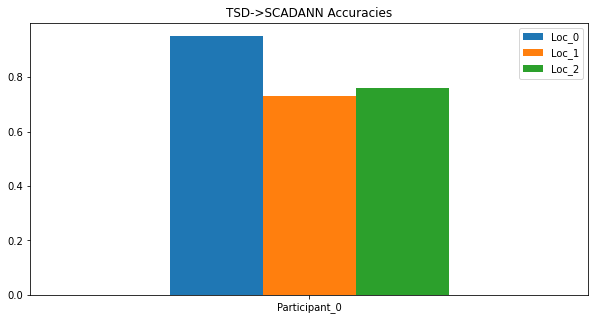

In [46]:
SCADANN_df.transpose().plot.bar(rot=0, figsize=(10,5))
plt.title("TSD->SCADANN Accuracies")
plt.show()

In [47]:
ground_truths = results[1]
predictions = results[2]
print("ground_truths  = ", np.shape(ground_truths))
print("predictions = ", np.shape(predictions))
m_name = "Sub"
n_name = "Loc"
df = get_gesture_accuracies(ground_truths, predictions, number_of_classes=number_of_classes, 
                            m_name=m_name, n_name=n_name, path=save_SCADANN, algo_name=algo_name)
df = pd.read_csv(save_SCADANN+'/'+algo_name+'.csv')
df

ground_truths  =  (1, 3)
predictions =  (1, 3)
index_participant_list  [0, 1, 2, 3, 4]
accuracies_gestures =  (22, 3)


,Unnamed: 0,Sub0_Loc0,Sub0_Loc1,Sub0_Loc2
0,M0,1.000000,1.000000,1.000000
1,M1,1.000000,0.792308,0.900000
2,M2,0.819231,0.538462,0.965385
3,M3,0.865385,0.450000,0.988462
4,M4,0.865385,0.673077,0.207692
5,M5,0.976923,0.538462,0.969231
6,M6,0.996154,0.642308,0.865385
7,M7,0.992308,0.757692,0.653846
8,M8,1.000000,0.988462,0.984615
9,M9,1.000000,0.869231,0.857692


# Conclusion
Suppose there is a ndarray of NxM dataloaders, then N group of models will be trained, and each group will have M model. Each group is independent of the other, and each model within a group is dependent on its previous training weights.

In general, overall accuracies of SCADANN are better than DANN, and DANN is better than TSD.
Occasionally accuracies of SCADANN end up a little smaller than DANN, reasons may be lack of datasets put into training model (fixed) and non-optimal percentage_same_gesture_sable (fixed). Code should be reproducible if processed dataset sticks to the shape defined above.  

The amount of increase in accuracies from DANN to SCADANN looks random. But if the base model is better at classifying one session, then its corresponding SCADANN is also better at classifying the same session. Given such result, to obtain the best performance from SCADANN, a good model trained with good data should be the starting point.

* What to check if sth goes wrong:
    * percentage_same_gesture_sable
    * number of cycles or sessions
    * shape of dataloaders (combination of train, test, valid should include all dataset)
    * shape of procssed datasets
    * directory paths of weights and results
    * if weights are stored or loaded correclty

In [48]:
print("ConvNet")
display(ConvNet_df)
print("ConvNet->DANN")
display(ConvNet_DANN_df)
print("ConvNet->SCADANN")
display(ConvNet_SCADANN_df)

ConvNet


,Participant_0
Loc_0,0.792133
Loc_1,0.535839
Loc_2,0.571154


ConvNet->DANN


,Participant_0
Loc_0,0.792133
Loc_1,0.576573
Loc_2,0.620455


ConvNet->SCADANN


,Participant_0
Loc_0,0.792133
Loc_1,0.641608
Loc_2,0.631119


In [49]:
print("TSD")
display(TSD_df)
print("TSD->DANN")
display(DANN_df)
print("TSD->SCADANN")
display(SCADANN_df)

TSD


,Participant_0
Loc_0,0.951748
Loc_1,0.69458
Loc_2,0.654371


TSD->DANN


,Participant_0
Loc_0,0.951748
Loc_1,0.698077
Loc_2,0.720455


TSD->SCADANN


,Participant_0
Loc_0,0.951748
Loc_1,0.731119
Loc_2,0.761014


In [50]:
diff_df = SCADANN_df-TSD_df
diff_df = diff_df.drop('Loc_0')
print("TSD->SCADANN")
display(diff_df)
diff_df.to_csv(save_TSD+'/diff_results/ConvNet_vs_TSD_TSD_side.csv')

TSD->SCADANN


,Participant_0
Loc_1,0.036538
Loc_2,0.106643


In [51]:
diff_df = ConvNet_SCADANN_df-ConvNet_df
diff_df = diff_df.drop('Loc_0')
print("ConvNet->SCADANN")
display(diff_df)
diff_df.to_csv(save_TSD+'/diff_results/ConvNet_vs_TSD_ConvNet_side.csv')

ConvNet->SCADANN


,Participant_0
Loc_1,0.105769
Loc_2,0.059965


In [52]:
overall_acc_df = pd.DataFrame([ConvNet_acc_overall, TSD_acc_overall, 
                               ConvNet_DANN_acc_overall, DANN_acc_overall, 
                               ConvNet_SCADANN_acc_overall, SCADANN_acc_overall],
                             index = ["ConvNet", "TSD", "ConvNet_DANN", "DANN", "ConvNet_SCADANN","SCADANN"],
                             columns = ["Overall_Acc"])
overall_acc_df

,Overall_Acc
ConvNet,0.633042
TSD,0.766900
ConvNet_DANN,0.663054
DANN,0.790093
ConvNet_SCADANN,0.688287
SCADANN,0.814627


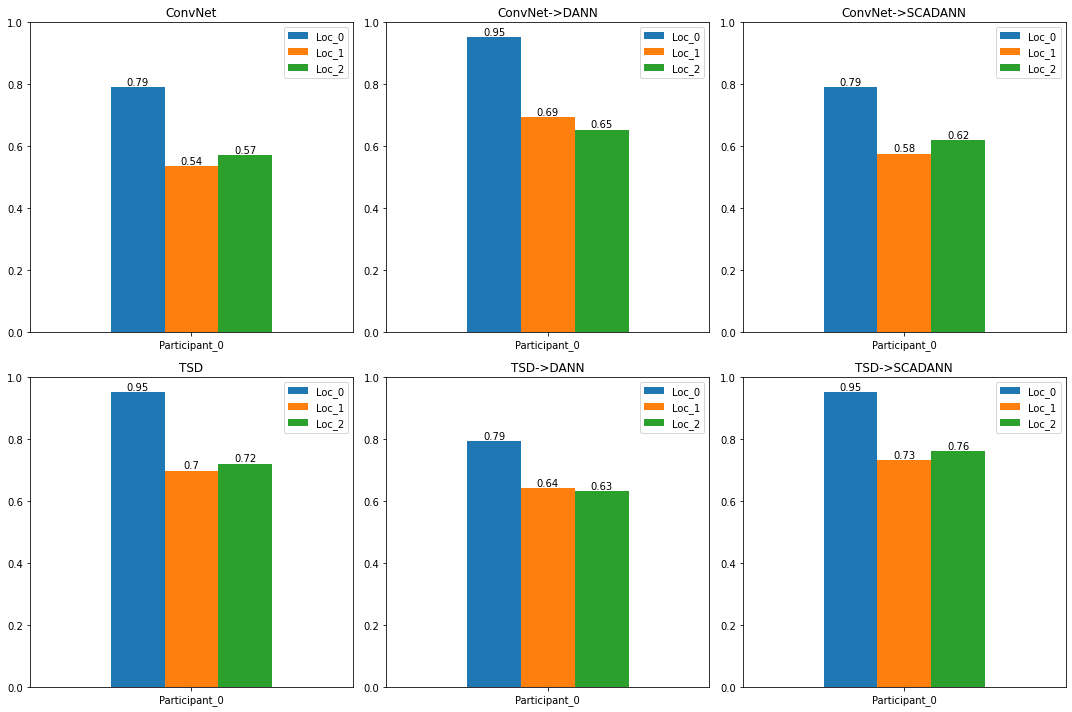

In [102]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
acc_list = [ConvNet_df, TSD_df, ConvNet_DANN_df, DANN_df, ConvNet_SCADANN_df, SCADANN_df]
title_list = ["ConvNet", "ConvNet->DANN", "ConvNet->SCADANN", "TSD", "TSD->DANN", "TSD->SCADANN"]
for idx, ax in enumerate(axes.reshape(-1)): 
    if idx < len(acc_list):
        acc_list[idx].transpose().plot.bar(ax = ax, rot=0)
        ax.set_title(title_list[idx])
        ax.set_ylim([0, 1.0])
        for p in ax.patches:
            ax.annotate(str(np.round(p.get_height(),2)), (p.get_x()+p.get_width()/2., p.get_height()),
                        ha='center', va='center', xytext=(0, 5),textcoords='offset points')


The comparison between ConvNet and TSD results proves that if the base model has better performance, so does its SCADANN model. However, there seems to be no relationship between accuracy increasement and whether the base model is good. 

The biggest increase in performance happens from TSD to SCADANN at wearing location 2 (from 65% to 76%), whereas the smallest increase happens at wearing location 1 of the same training direction (from 69% to 73%). Similarly, SCADANN trained based on ConvNet increases by 11% (from 53% to 64%) at wearing location 1, but it only increases by 6% (from 57% to 63%) at wearing location 2. So, it is possible for SCADANN to largely increase accuracy of one sesssion while keeping a low overall accuracy. 

,ConvNet,TSD
Base Model,0.633042,0.766900
DANN,0.663054,0.790093
SCADANN,0.688287,0.814627


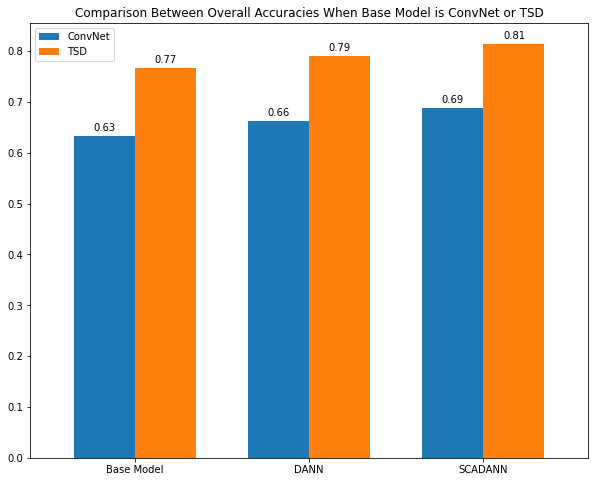

In [74]:
overall_acc_df = pd.DataFrame([[ConvNet_acc_overall, TSD_acc_overall], 
                               [ConvNet_DANN_acc_overall, DANN_acc_overall], 
                               [ConvNet_SCADANN_acc_overall, SCADANN_acc_overall]], 
                             columns =['ConvNet', 'TSD'], index=['Base Model', 'DANN', 'SCADANN'])
display(overall_acc_df)                              
ax = overall_acc_df.plot(kind='bar', figsize=(10,8), width=0.7, linewidth=8)
for p in ax.patches:
    ax.annotate(str(np.round(p.get_height(),2)), (p.get_x()+p.get_width()/2., p.get_height()),
                ha='center', va='center', xytext=(0, 8),textcoords='offset points')
plt.xticks(rotation=0)
plt.title('Comparison Between Overall Accuracies When Base Model is ConvNet or TSD')
plt.show()